Water Quality Example

### This Notebook is under devleopment. 

## Initialise

In [34]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/jovyan/odc-hub/')


import datacube
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

from sac_utils.createAOI import create_lat_lon
from utils_dcal.data_cube_utilities.dc_display_map import display_map
from sac_utils.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic

dc = datacube.Datacube(app='waterquality-example')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Variables

In [8]:
#area of interest: load in as wkt
#smallish area for testing
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#larger area for testing
#aoi_wkt = "POLYGON((177.43329863711836 -17.52948354640883,177.76975493594648 -17.52948354640883,177.76975493594648 -17.826499420595315,177.43329863711836 -17.826499420595315,177.43329863711836 -17.52948354640883))"
#set-project: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"
#set resolution_if using Landsat min 30m, if sentinel min 10m 
res = (30)
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform_base = 'LANDSAT_8'

In [9]:
#set baseline start and end of period
baseline_start_date = '2015-3-1'
baseline_end_date = '2015-9-1'
# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
mosaic_type = "max_ndvi"

## Create AOI

In [10]:

lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [13]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [14]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
    else:
        print("invalid platform")
    return product, measurements 

In [15]:
baseline_product, baseline_measurement = create_product_measurement(platform_base)

In [16]:
#create resolution
resolution = (-res, res)

In [19]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

print(baseline_time_period)

(datetime.date(2015, 3, 1), datetime.date(2015, 9, 1))


## Set up datacube query

In [20]:
#query = {}
#query['product'] = 's2_esa_sr_granule'  # for this example we will load some data from Landsat 8
#query['output_crs'] = 'EPSG:3460'  # let's output our data in the Fiji projection
#query['group_by'] = 'solar_day'  # datasets can often overlap, we will combine all data that occurs on the same day

In [21]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'group_by': 'solar_day',
    'output_crs': output_projection,  
    'resolution': resolution
}

In [22]:
baseline_ds = dc.load(
    time = baseline_time_period,
    platform = platform_base,
    product = baseline_product,
    measurements = baseline_measurement,
    **query
)

## Check if loads are valid

In [25]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [26]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

## Create Cloud Mask

In [30]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform_base)

In [48]:
baseline_ds_new = baseline_ds.where(baseline_clean_mask)

In [ ]:
c

## Perform Mosaic


In [35]:
#add in geomedian - get rid of others
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [36]:
new_compositor = mosaic_function[mosaic_type]

## Load and Visualise Area of interest

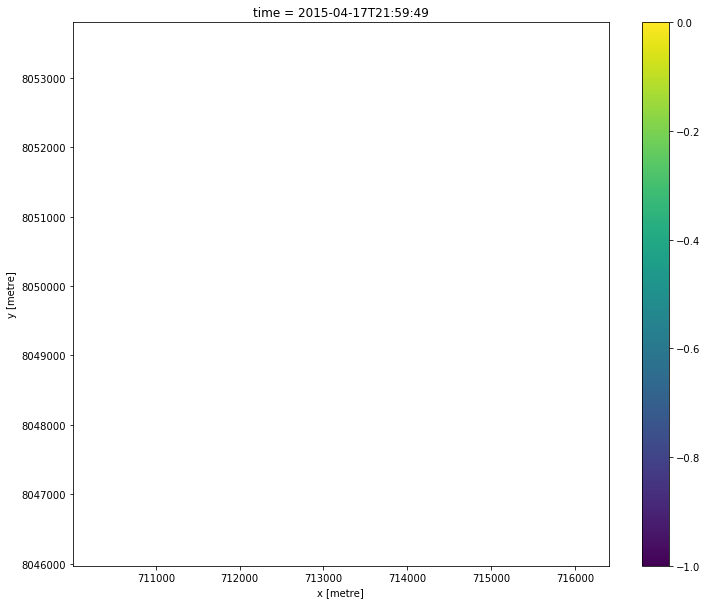

In [49]:
def NDTI(ds):
    return np.divide((ds.red-ds.green), (ds.red+ds.green))

calNDTI = NDTI(baseline_ds_new)

calNDTI.isel(time=5).plot(figsize = (12, 10), vmin = -1, vmax = 0) 

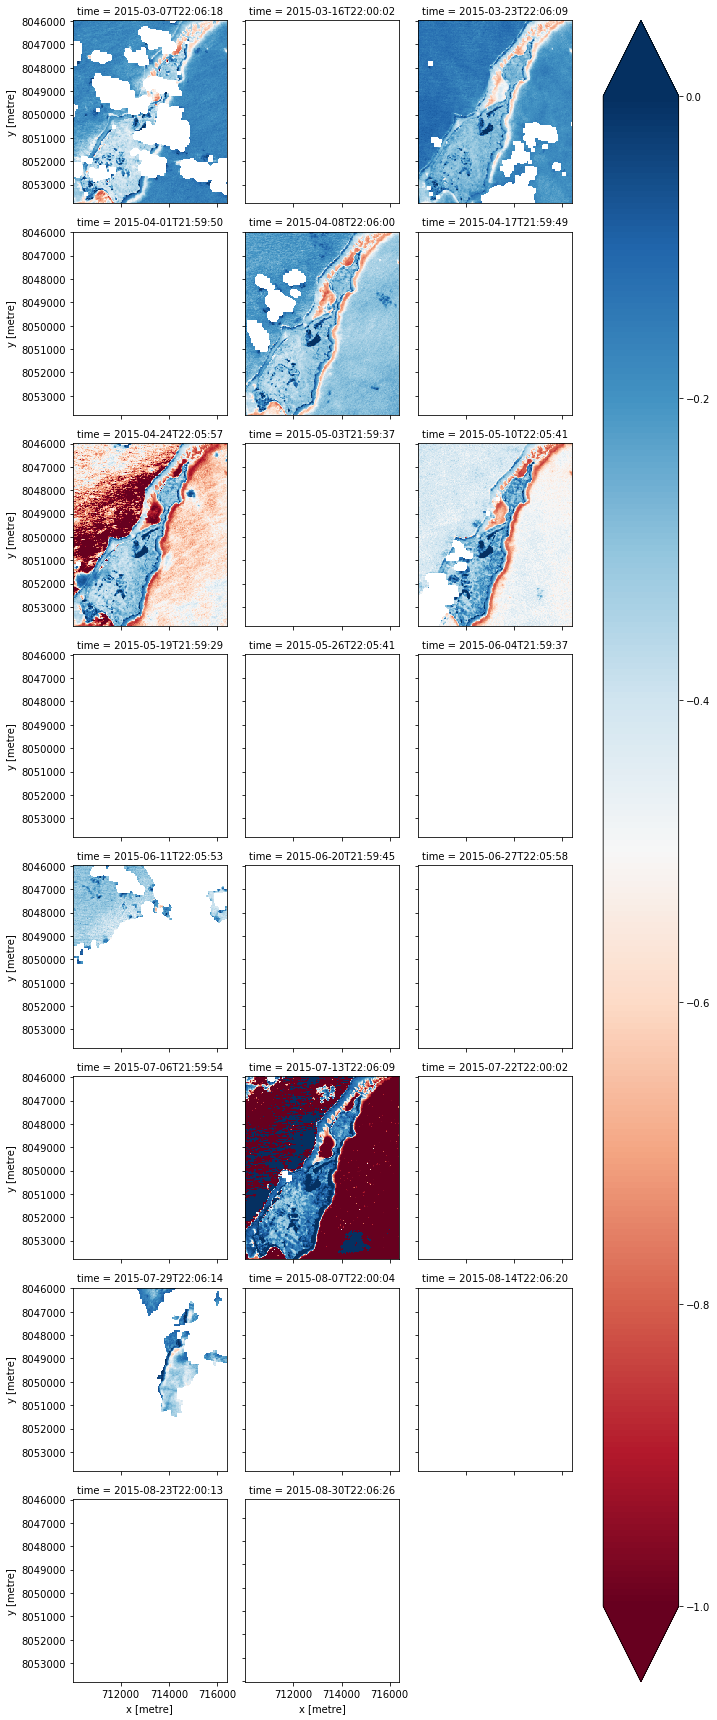

In [58]:
calNDTI.plot(col='time', cmap='RdBu', col_wrap=3, vmin=-1, vmax=0)

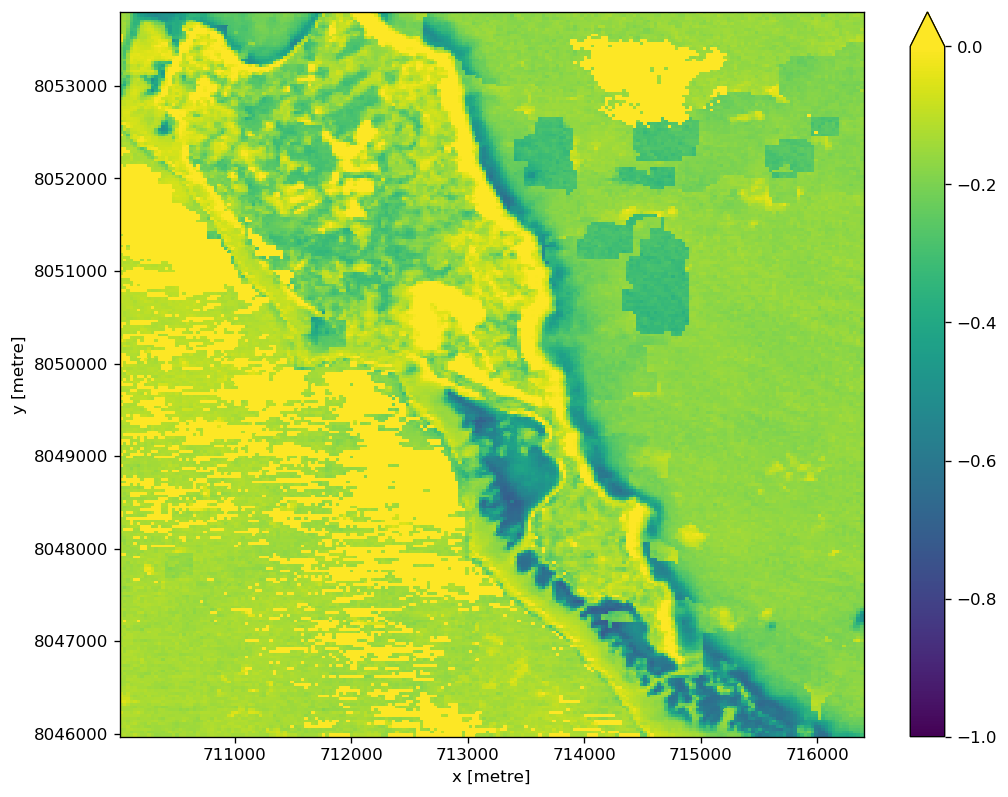

In [59]:
plt.figure(figsize = (10,8), dpi=120)
calNDTI.max(dim = 'time').plot(vmin = -1, vmax = 0);

In [51]:
plt.figure(figsize = (10,8), dpi=120)
calNDTI.median(dim = 'time').plot(vmin = -1, vmax = 1);

NameError: name 'clearsky_scenes' is not defined